## Objectives (for now)

* Write a program to recognize named entities in text
* Learn how to manage a text data set better
* Apply recurrent neural networks to text with PyTorch
* Get a better feel for what word embeddings are

### Imports


In [2]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import conlleval

In [3]:
random.seed(1234)
torch.manual_seed(1234)

### Constants

In [4]:
EPOCHS = 10
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 2
DROPOUT = 0.20
EMB_LARGE = False # GloVe 50 or 100
FREEZE_EMBS = True
LARGE_MEM = False

In [5]:
config = {'EPOCHS': EPOCHS, 
'LSTM_HIDDEN_DIM': LSTM_HIDDEN_DIM,
'LSTM_LAYERS': LSTM_LAYERS,
'DROPOUT': DROPOUT,
'EMB_LARGE': EMB_LARGE,
'FREEZE_EMBS': FREEZE_EMBS}

### The datasets
dowloads and fixes everything for simplicity's sake

In [ ]:
!wget https://data.deepai.org/conll2003.zip
!unzip -u conll2003.zip
!mkdir conll2003
!mv train.txt valid.txt test.txt conll2003
!rm conll2003.zip
#Download GloVe dataset as well

In [6]:
train_file = 'conll2003/train.txt'
val_file = 'conll2003/valid.txt'
test_file = 'conll2003/test.txt'

## Reading the files

In [7]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [8]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

CoNLL files have four columns: wordform, `form`,  predicted part of speech, `ppos`, predicted tag denoting the syntactic group aka chunk tag, `pchunk`, and named entity tag `ner`.

In [9]:
column_names = ['form', 'ppos', 'pchunk', 'ner']

Load the corpus as a list of dictionaries

In [10]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)

val_sentences = read_sentences(val_file)
val_dict = split_rows(val_sentences, column_names)

train_dict[1]

[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'},
 {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'},
 {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
 {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
 {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'},
 {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'},
 {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
 {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]

## Embeddings

In [11]:
if EMB_LARGE:
    embedding_file = "glove\glove.6B.100d.txt"
    EMBEDDING_DIM = 100
else:
    embedding_file = "glove\glove.6B.50d.txt"
    EMBEDDING_DIM = 50

The function below reads GloVe embeddings and store them in a dict, where keys will be the words and the values are embedding vectors.

In [12]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [15]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

In [16]:
'# words in embedding dictionary: {}'.format(len(embedded_words))

'# words in embedding dictionary: 400000'

In [18]:
embeddings_dict['the']

tensor([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [20]:
E = []
emb_word_idx = {}
count = 0
list1 = []
for word in embeddings_dict :
    emb_word_idx[count] = word
    count+=1
    list1.append(embeddings_dict[word])
E = torch.stack(list1)
    

Normalize the rows so that each row has a norm of 1

In [23]:
E = torch.nn.functional.normalize(E, dim=1)

In [24]:
torch.linalg.vector_norm(E[2222], ord=2)

tensor(1.)

Using a cosine similarity, compute the 10 closest rows of a given vector `target_word_embeddings`.

$$
\cos(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}|| ||\mathbf{v}||}
$$

In [25]:
def closest(target_word_emb, E, count=10):

    cos_sims = torch.matmul(E, target_word_emb.T) / (torch.norm(E, dim=1, p = 2) * torch.norm(target_word_emb, p=2))

    closest_ids = torch.topk(cos_sims.view(-1), k=count+1).indices.tolist()
    print(cos_sims.shape)
    closest_ids.pop(0)
    return closest_ids                    

Using the `closest()` function find the words closest to _table_, _france_, and _sweden_.

In [26]:
embeddings_dict['table'][:20]

tensor([-0.3666,  1.0584, -0.6538,  0.1767,  1.0605, -0.7254, -0.0097,  0.0797,
        -0.4649, -0.7435, -0.6415, -0.1684, -0.4893,  0.5667,  0.7310,  0.1839,
         0.3437, -0.1916,  0.0661, -1.3434])

In [27]:
closest(embeddings_dict['table'], E, count=10)

torch.Size([400000])


C:\Users\Faraz\AppData\Local\Temp\ipykernel_8508\1120754783.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  cos_sims = torch.matmul(E, target_word_emb.T) / (torch.norm(E, dim=1, p = 2) * torch.norm(target_word_emb, p=2))


[7221, 241, 3162, 208, 310, 802, 187, 236, 2389, 220]

In [29]:
list(map(emb_word_idx.get, closest(embeddings_dict['france'], E, count=10)))

torch.Size([400000])


['french',
 'belgium',
 'paris',
 'spain',
 'netherlands',
 'italy',
 'germany',
 'european',
 'switzerland',
 'europe']

## Extracting the ${X}$ and ${Y}$ Lists of Symbols from the Datasets

For the 2nd sentence of the training set, should be if I did it correctly:<br/>
`x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']`

`y = ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']`

In [30]:
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    x_list = []
    y_list = []
    for sentence in corpus_dict:
        x_temp = []
        y_temp = []
        for word in sentence:
            x_temp.append(word.get(key_x).lower())
            y_temp.append(word.get(key_y))
        x_list.append(x_temp)
        y_list.append(y_temp)
            
    return x_list, y_list

In [31]:
train_dict[1][2].get('pos')

In [32]:
X_train_symbs, Y_train_symbs = build_sequences(train_dict, key_x='form', key_y='ner')
X_val_symbs, Y_val_symbs = build_sequences(val_dict, key_x='form', key_y='ner')

In [34]:
X_train_symbs[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [35]:
Y_train_symbs[1]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

## Vocabulary

Vocabulary of all the words observed in the training set as well as in GloVe. 

First extract the list of unique words `words` from the CoNLL training set and the list of NER tags, `ner`.

In [37]:
words = set()
for scentence in X_train_symbs:
    for word in scentence:
        words.add(word)
word_list = sorted(words)

In [38]:
tags = set()
for row in Y_train_symbs:
    for tag in row:
        tags.add(tag)
tag_list = sorted(tags)

In [39]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(tags))

# words seen in training corpus: 21010
# NER tags seen: 9


In [41]:
word_list[4000:4010]

['adequate',
 'adige',
 'adj',
 'adjourned',
 'adjust',
 'adjusted',
 'adjusting',
 'adjustments',
 'adkins',
 'administer']

In [42]:
tag_list[:10]

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Then, merge the list of CoNLL words with the words in the embeddings file

In [43]:
vocabulary_words = set(word_list).union(set(embedded_words))
vocabulary_words = sorted(list(vocabulary_words))

In [44]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create the indices `word2idx`, `tag2idx` and inverted indices `idx2word`, `idx2tag` for the words and the tags. Index 0 for the padding symbol and 1 for unknown words. This means that the first word will start at index 2. For the tags, you will start at index 1.

In [47]:
word2idx = {}
tag2idx = {}
count = 2
for word in vocabulary_words:
    word2idx[word] = count
    count+=1
count = 1
for tag in tag_list:
    tag2idx[tag] = count
    count+=1

In [48]:
idx2word = {v: k for k, v in word2idx.items()}
idx2word

{2: '!',
 3: '!!',
 4: '!!!',
 5: '!!!!',
 6: '!!!!!',
 7: '!?',
 8: '!?!',
 9: '"',
 10: '#',
 11: '##',
 12: '###',
 13: '#a',
 14: '#aabccc',
 15: '#b',
 16: '#c',
 17: '#cc',
 18: '#ccc',
 19: '#cccccc',
 20: '#ccccff',
 21: '#d',
 22: '#daa',
 23: '#dcdcdc',
 24: '#e',
 25: '#f',
 26: '#faf',
 27: '#ff',
 28: '#ffffff',
 29: '#m',
 30: '#p',
 31: '#s',
 32: '#the',
 33: '#ukqa',
 34: '#ukqaqfqs',
 35: '#ukqaqs',
 36: '#ukqaqsqf',
 37: '#ukqaqsqm',
 38: '#ukqaqtqszbzszr',
 39: '#ukqec',
 40: '#ukqeqtqszb',
 41: '$',
 42: '%',
 43: '&',
 44: '&#8211;',
 45: '&#8217;',
 46: '&#8220;',
 47: '&#8221;',
 48: '&amp;',
 49: "'",
 50: "''",
 51: "'00",
 52: "'01",
 53: "'02",
 54: "'03",
 55: "'04",
 56: "'05",
 57: "'06",
 58: "'07",
 59: "'08",
 60: "'09",
 61: "'10",
 62: "'11",
 63: "'12",
 64: "'13",
 65: "'14",
 66: "'15",
 67: "'20",
 68: "'20s",
 69: "'25",
 70: "'27",
 71: "'28",
 72: "'29",
 73: "'30",
 74: "'30s",
 75: "'32",
 76: "'34",
 77: "'36",
 78: "'37",
 79: "'38",
 80: 

In [49]:
idx2tag = {v: k for k, v in tag2idx.items()}


In [50]:
word2idx['table']

353523

The word indices

In [51]:
print(list(word2idx.items())[:25])

[('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]


The tag indices

In [52]:
print(tag2idx)

{'B-LOC': 1, 'B-MISC': 2, 'B-ORG': 3, 'B-PER': 4, 'I-LOC': 5, 'I-MISC': 6, 'I-ORG': 7, 'I-PER': 8, 'O': 9}


## Embedding Matrix

Matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `torch.rand()`

In [53]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))/10 - 0.05 # range: -0.05, 0.05, 
# embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = torch.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

In [54]:
embedding_matrix.shape

torch.Size([402597, 50])

Fill the matrix with the GloVe embeddings when available. This means: Replace the random vector with an embedding when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [58]:
voc_set = set(vocabulary_words)
embedded_set = set(embedded_words)
out_of_embeddings = [None] * len(voc_set)
count = 0
for word in tqdm(voc_set) :
    if word in embedded_set:
        embedding_matrix[word2idx[word]] = embeddings_dict[word]
    else:
        out_of_embeddings[count] = word
        count +=1
out_of_embeddings = out_of_embeddings[:count]


100%|██████████| 402595/402595 [00:03<00:00, 108747.86it/s]


In [59]:
voc_set = set(vocabulary_words)
len(vocabulary_words)

402595

In [60]:
out_of_embeddings

['4-200',
 'steady-higher',
 '10,896',
 'niggled',
 'etchebarren',
 '10no',
 '26.7.1996',
 '17-0-91-0',
 'bayervb',
 'bulatka',
 'zafririm',
 '133.82',
 'destocked',
 '11.776',
 'takeishi',
 'rhineside',
 '28-inning',
 '2320.00',
 '3-146',
 '6700.000',
 'schwabl',
 'half-percentage',
 'shi-ting',
 'earth-shattering',
 '53rd-ranked',
 '170.4-175.0',
 'fehervar',
 '+0.9;+23.6',
 '234,324',
 'camat',
 '20.036',
 '44,525',
 '1464/96',
 '38:18.759',
 'common-cold',
 'rica-nicaragua',
 'buzuku',
 '44th-ranked',
 'mafia-style',
 'well-flighted',
 '10-1-39-1',
 '482-1003',
 '214.40',
 'green-and-yellow',
 '35-7/8',
 'abderdeen',
 '20,725',
 '7-1/3',
 '28,716.8',
 'micromation',
 'stephnopoulos',
 '109.36',
 'hintum',
 '02.sep.96-21.nov.97',
 '266.37',
 'house-hunting',
 '17.',
 '251/08',
 '23-5-71-1',
 '2,017.99',
 'syrian-lebanese',
 '10-0-59-1',
 'leciva',
 'still-enslaved',
 'much-larger',
 'agrotonz',
 '03/09',
 'chabora',
 '1ama',
 '161,600',
 '1996-08-29',
 'cellar-dwellers',
 '1996-08-2

In [61]:
embeddings_dict['chord']

tensor([ 0.1357, -0.0910, -0.1032, -0.3671,  0.2028,  1.4460,  1.1740,  0.4656,
        -0.8072,  0.8025, -0.1076, -0.3101, -0.3294,  0.8699, -1.5335, -0.7010,
        -0.6835, -1.0930,  0.1873, -0.3392, -1.2767, -1.0122, -0.2891,  0.9744,
         0.9689,  0.1969, -0.6227,  0.0934,  0.4631, -0.2058,  2.2427, -0.1040,
         1.4332,  0.5460,  0.0782, -0.6911,  0.6938, -0.6075, -0.4844,  0.9767,
         0.1653, -0.0863, -1.2616,  0.3105,  0.0223,  0.9487,  1.1302, -0.0348,
        -0.5622,  0.5346])

In [63]:
len(out_of_embeddings)

2595

In [65]:
out_of_embeddings = sorted(out_of_embeddings)

Embeddings of the padding symbol, idx 0, random numbers

In [66]:
embedding_matrix[word2idx['table']][:10]

tensor([-0.3666,  1.0584, -0.6538,  0.1767,  1.0605, -0.7254, -0.0097,  0.0797,
        -0.4649, -0.7435])

Embeddings of the word _table_, the GloVe values

In [68]:
embedding_matrix[word2idx['zwingmann']][:10]

tensor([-0.0014,  0.0307,  0.0219, -0.0102,  0.0266,  0.0387, -0.0300, -0.0342,
         0.0384,  0.0363])

Embeddings of _zarett_, a word in CoNLL 2003, but not in GloVe, random numbers

## Creating the ${X}$ and ${Y}$ Sequences

In [69]:
# We create the parallel sequences of indexes
X_train_idx = []
Y_train_idx = []
for sentence in X_train_symbs:
    sentence_list = []
    for word in sentence:
        sentence_list.append(word2idx[word])
    X_train_idx.append(sentence_list)
    
for sentence in Y_train_symbs:
    sentence_list = []
    for word in sentence:
        sentence_list.append(tag2idx[word])
    Y_train_idx.append(sentence_list)


Do the same for the validation set. Some words are unknown.

In [70]:
X_val_idx = []
Y_val_idx = []
for sentence in X_val_symbs:
    sentence_list = []
    for word in sentence:
        if word in word2idx :
            sentence_list.append(word2idx[word])
        else:
            sentence_list.append(1)

    X_val_idx.append(sentence_list)
    
for sentence in Y_val_symbs:
    sentence_list = []
    for word in sentence:
        if word in tag2idx :
            sentence_list.append(tag2idx[word])
        else:
            sentence_list.append([1])
    Y_val_idx.append(sentence_list)


Word indices of the three first sentences

In [71]:
print(X_train_idx[:3])
print(X_val_idx[:3])

[[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
[[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936], [227217, 15431]]


NER tag indices of the three first sentences

In [72]:
print(Y_train_idx[:3])
print(Y_val_idx[:3])

[[9], [3, 9, 2, 9, 9, 9, 2, 9, 9], [4, 8]]
[[9], [9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9], [1, 9]]


In [73]:
X_train_idx = list(map(torch.LongTensor, X_train_idx))
Y_train_idx = list(map(torch.LongTensor, Y_train_idx))

X_val_idx = list(map(torch.LongTensor, X_val_idx))
Y_val_idx = list(map(torch.LongTensor, Y_val_idx))

In [74]:
X_train_padded = pad_sequence(X_train_idx, batch_first=True)
Y_train_padded = pad_sequence(Y_train_idx, batch_first=True)

X_val_padded = pad_sequence(X_val_idx, batch_first=True)
Y_val_padded = pad_sequence(Y_val_idx, batch_first=True)

In [76]:
X_train_padded[1]

tensor([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,    936,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [77]:
Y_train_padded[1]

tensor([3, 9, 2, 9, 9, 9, 2, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Network Architecture

In [544]:
#LSTM
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self, embedding_matrix, lstm_units, nbr_classes, freeze_embs=True, num_layers=1, bidi_lstm=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embs, padding_idx=0)
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(embedding_matrix.shape[1], lstm_units, num_layers=num_layers, bidirectional=bidi_lstm, batch_first=True)

        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            # twice the units if bidirectional 
            self.fc = nn.Linear(2*lstm_units, nbr_classes)
            
    def forward(self, sentence):
        embeds = self.embedding(sentence)
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        lstm_last = F.relu(lstm_out)
        lstm_last = self.dropout(lstm_last)
        logits = self.fc(lstm_last)
        return logits

In [136]:
#multi-layer Elman RNN with tanh⁡tanh or ReLUReLU non-linearity to an input sequence
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self, embedding_matrix, rnn_units, nbr_classes, freeze_embs=True, num_layers=1, bidi_rnn=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embs, padding_idx=0)
        self.dropout = nn.Dropout(DROPOUT)
        self.rnn = nn.RNN(embedding_matrix.shape[1], rnn_units, num_layers=num_layers, bidirectional=bidi_rnn, batch_first=True)

        if not bidi_rnn:
            self.fc = nn.Linear(rnn_units, nbr_classes)
        else:
            self.fc = nn.Linear(2*rnn_units, nbr_classes)
            
    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rnn_out, h_n = self.rnn(embeds)
        rnn_last = F.relu(rnn_out)
        rnn_last = self.dropout(rnn_last)
        logits = self.fc(rnn_last)
        return logits


In [192]:
model = Model(embedding_matrix, 
              LSTM_HIDDEN_DIM, 
              len(tags) + 1, 
              freeze_embs=True, 
              num_layers=2, 
              )#bidi_lstm=True)

In [194]:
model

Model(
  (embedding): Embedding(402597, 50, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): RNN(50, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

The loss `loss_fn` and optimizer `optimizer`.

Note that to compute the loss, you need to discard the padding symbols from the results and specify their index 
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html (ignore_index)

In [195]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

## Data Loaders

In [196]:
X_train = torch.LongTensor(X_train_padded)
Y_train = torch.LongTensor(Y_train_padded)

X_val = torch.LongTensor(X_val_padded)
Y_val = torch.LongTensor(Y_val_padded)

In [197]:
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Applying the Model

We apply the model to the whole training set.

In [198]:
def batch_inference(model, X, batchsize=32):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [199]:
with torch.no_grad():
    Y_train_pred = batch_inference(model, X_train)

In [200]:
Y_train_pred.size()

torch.Size([14987, 113, 10])

In [201]:
Y_train_pred.view(-1, Y_train_pred.size()[-1]).size()

torch.Size([1693531, 10])

## Training the Model

We create a dictionary to store the accuracy and the loss. Computes them in the training loop. Excludes the the padding symbols from counts. 

In [202]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

Need to buy new machine that supports Cuda, broke life as a student aint easy

In [203]:
torch.cuda.is_available

<function torch.cuda.is_available() -> bool>

We fit the model

In [204]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        batch_cnt += 1
        Y_batch_pred = model(X_batch)
        loss = loss_fn(Y_batch_pred.view(-1, Y_batch_pred.shape[-1]), y_batch.view(-1)) # reshape Y_batch_pred
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
       
    
    model.eval()
    with torch.no_grad():
        train_accuracy = torch.sum(torch.mul(torch.argmax(batch_inference(model, X_train), dim = -1) == Y_train, Y_train > 0))
     
        history['accuracy'] += [train_accuracy.item()/torch.sum(Y_train > 0)]
        history['loss'] += [train_loss/batch_cnt]
        
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred.view(-1, y_val_pred.shape[-1]), Y_val.view(-1))
        history['val_loss'] += [val_loss.item()]
        val_accuracy = torch.sum(torch.mul(torch.argmax(model(X_val), dim=-1) == Y_val, Y_val > 0))
        history['val_accuracy'] += [val_accuracy.item()/torch.sum(Y_val > 0)]


100%|██████████| 469/469 [00:32<00:00, 14.57it/s]


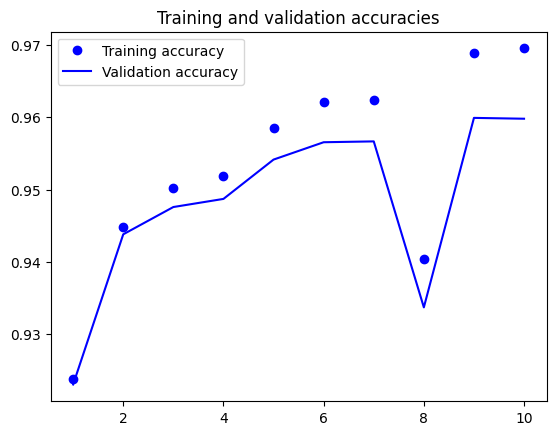

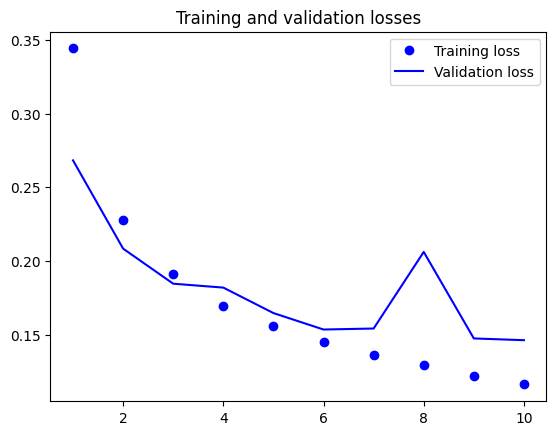

In [206]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

And we visualize the training curves. We compare them with a validation set.

In [209]:
sentence = 'The United States might collapsez .'.lower().split()

Convert the sentence words to indices

In [210]:
sentence_word_idxs = []
for word in sentence :
    if word in word2idx :
        sentence_word_idxs.append(word2idx[word])
    else :
        sentence_word_idxs.append(1)
sentence_word_idxs = torch.LongTensor(sentence_word_idxs)

The indices. Note the 1 at the end.

In [211]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['the', 'united', 'states', 'might', 'collapsez', '.']
Sentence word indexes tensor([359698, 374678, 344404, 246008,      1,    936])


Predict the tags. Call the variable `sent_tag_predictions`

In [212]:
sent_tag_predictions = model(sentence_word_idxs)

In [214]:
sent_tag_predictions.shape

torch.Size([6, 10])

The estimated probabilities of the first tag

In [215]:
F.softmax(sent_tag_predictions[0], dim=-1)

tensor([2.2006e-12, 1.1678e-04, 6.9366e-04, 7.1028e-03, 3.1984e-06, 9.2650e-06,
        1.4142e-04, 1.0985e-04, 6.5737e-07, 9.9182e-01],
       grad_fn=<SoftmaxBackward0>)

In [217]:
torch.argmax(F.softmax(sent_tag_predictions, dim=-1), dim=-1)

tensor([9, 1, 5, 9, 9, 9])

We apply argmax to select the tag

In [220]:
for word_nbr, tag_predictions in enumerate(sent_tag_predictions):
    if int(sentence_word_idxs[word_nbr]) in idx2word:
        print(idx2word[int(sentence_word_idxs[word_nbr])], end=': ')
    else:
        print(sentence[word_nbr], '/ukn', end=': ')
    print(idx2tag.get(int(torch.argmax(F.softmax(tag_predictions, dim=-1), dim=-1))))

the: O
united: B-LOC
states: I-LOC
might: O
collapsez /ukn: O
.: O


## Evaluating the Model

In [222]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O'},
  {'form': 'JAPAN', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-LOC'},
  {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O'},
  {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O'},
  {'form': 'CHINA', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-PER'},
  {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O'},
  {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]]

We create the ${X}$ and ${Y}$ sequences of symbols

In [223]:
X_test_symbs, Y_test_symbs = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test_symbs[1])
print('Y_test', Y_test_symbs[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


In [224]:
X_test_idx = []
for x in X_test_symbs:
    # We map the unknown words to index 1
    x_idx = list(map(lambda a: word2idx.get(a, 1), x))
    X_test_idx += [x_idx]

In [225]:
X_test_idx = map(torch.LongTensor, X_test_idx)

In [226]:
X_test_padded = pad_sequence(X_test_idx, batch_first=True)

In [227]:
print('X_test_padded:', X_test_padded[1])

X_test_padded: tensor([338644,    679, 197600, 162137, 229067, 390518,    517, 100680, 190291,
        350949, 120818,    936,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,  

In [228]:
X_test_padded.shape

torch.Size([3684, 124])

Predict the NER tags. Call the result `Y_test_hat_probs`

In [229]:
Y_test_hat_probs = batch_inference(model, X_test_padded)

In [232]:
print('Predictions', Y_test_hat_probs[1])

Predictions tensor([[-24.6871,  -6.1796,  -0.8955,  ...,  -3.9058,  -9.3320,   4.0271],
        [-24.1049,  -4.0013,  -2.8348,  ...,  -3.2763,  -9.0496,   4.5298],
        [-21.0066,   4.8963,   2.3607,  ...,  -5.4691,  -8.9876,  -1.9908],
        ...,
        [-16.9128,  -3.3277,  -3.1517,  ...,  -4.3740,  -1.2815,   1.3175],
        [-16.9128,  -3.3277,  -3.1517,  ...,  -4.3740,  -1.2815,   1.3175],
        [-16.9127,  -3.3277,  -3.1517,  ...,  -4.3740,  -1.2815,   1.3175]])


In [233]:
Y_test_hat_probs = F.softmax(Y_test_hat_probs, dim=-1)

In [234]:
Y_test_hat_probs[1]

tensor([[3.3400e-13, 3.6430e-05, 7.1834e-03,  ..., 3.5397e-04, 1.5573e-06,
         9.8668e-01],
        [3.6513e-13, 1.9648e-04, 6.3081e-04,  ..., 4.0568e-04, 1.2615e-06,
         9.9619e-01],
        [5.1726e-12, 9.1872e-01, 7.2782e-02,  ..., 2.8945e-05, 8.5800e-07,
         9.3793e-04],
        ...,
        [1.0451e-08, 8.3001e-03, 9.8981e-03,  ..., 2.9153e-03, 6.4235e-02,
         8.6394e-01],
        [1.0452e-08, 8.3001e-03, 9.8980e-03,  ..., 2.9154e-03, 6.4235e-02,
         8.6394e-01],
        [1.0452e-08, 8.3002e-03, 9.8980e-03,  ..., 2.9154e-03, 6.4235e-02,
         8.6394e-01]])

We now predict the whole test set and we store the results in each dictionary with the key `pner`

In [235]:
for sent, y_hat_probs in zip(test_dict, Y_test_hat_probs):
    sent_len = len(sent)
    y_hat_probs = y_hat_probs[:sent_len]
    # y_hat = torch.argmax(y_hat_probs, dim=-1) # This statement sometimes predicts 0 (the padding symbol)
    y_hat = torch.argmax(y_hat_probs[:, 1:], dim=-1) + 1 # Never predicts 0
    for word, ner_hat in zip(sent, y_hat):
        word['pner'] = idx2tag.get(int(ner_hat)) 
        if word['pner'] == None:
            print(sent)

A sentence example: `ner` is the hand annotation and `pner` is the prediction.

We save the test set in a file to evaluate the performance of our model.

In [237]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [238]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [239]:
outfile = 'test_model.out'

In [240]:
save(outfile, test_dict, column_names)

In [241]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.743120863810519

In [242]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.743120863810519

In [189]:
config

{'EPOCHS': 10,
 'LSTM_HIDDEN_DIM': 128,
 'LSTM_LAYERS': 2,
 'DROPOUT': 0.2,
 'EMB_LARGE': False,
 'FREEZE_EMBS': True}

In [190]:
torch.save(model.state_dict(), 'model3.pth')

## Experiments

Two different recurrent networks: RNN and LSTM. Two sets of parameters per network. 

|Method|Parameters|Score|
|------|-----|-----|
|Baseline|  xx | 0.7191 |
|LSTM|  {'EPOCHS': 10,'LSTM_HIDDEN_DIM': 128,'LSTM_LAYERS': 2,'DROPOUT': 0.2,'EMB_LARGE': False, 'FREEZE_EMBS': True} |0.825944606671976 |
|LSTM |  {'EPOCHS': 10, 'LSTM_HIDDEN_DIM': 256,'LSTM_LAYERS': 3,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': False} |0.05489926214779982 |
|LSTM | {'EPOCHS': 10,'LSTM_HIDDEN_DIM': 256,'LSTM_LAYERS': 2,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True} | 0.8316867253457876|
|LSTM |  {'EPOCHS': 10,'LSTM_HIDDEN_DIM': 128,'LSTM_LAYERS': 3,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True} |0.8404753330932662  Would've been 8th place | 
|RNN |  {'EPOCHS': 10,'RNN_UNITS': 128,'LAYERS': 2,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True}|0.7473235268517712 |
|RNN |  {'EPOCHS': 10,'RNN_UNITS': 128,'LAYERS': 2,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': False}|0.6948544741889751 |
|RNN |  {'EPOCHS': 10,'RNN_UNITS': 128*2,'LAYERS': 3,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True}| 0.6737652551396511|
|RNN |  {'EPOCHS': 10,'RNN_UNITS': 128*3,'LAYERS': 2,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True}| 0.7343036775471536|
|RNN |  {'EPOCHS': 10,'RNN_UNITS': 128*3,'LAYERS': 3,'DROPOUT': 0.2,'EMB_LARGE': False,'FREEZE_EMBS': True}| 0.7398885493438792|

The baseline is the one from the CoNLL 2003 shared task. See here: https://aclanthology.org/W03-0419.pdf

My goal is 80%